In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from scipy import stats, fft
from datetime import timedelta



In [ ]:
path = r"C:/Users/rouat/Downloads/dataset1-1.csv"
df = pd.read_csv(path)
df.head(4)

cow        date  hour  IN_ALLEYS      REST       EAT  ACTIVITY_LEVEL  \
0  6601  2018-10-25    11   1603.585  1355.386    41.024       -37.93510   
1  6601  2018-10-25    12   1586.965   138.501  1874.528      1009.36093   
2  6601  2018-10-25    13   1442.930   567.066  1584.866       766.08734   
3  6601  2018-10-25    14    209.571  2728.410   662.013      -315.95748   

   oestrus  calving  lameness  mastitis  LPS  acidosis  other_disease  \
0        0        0         0         0    0       NaN              0   
1        0        0         0         0    0       NaN              0   
2        0        0         0         0    0       NaN              0   
3        0        0         0         0    0       NaN              0   

   accidents  disturbance  mixing  management_changes  OK  
0          0            0       0                   0   1  
1          0            0       0                   0   1  
2          0            0       0                   0   1  
3          0            0       0                   0   1

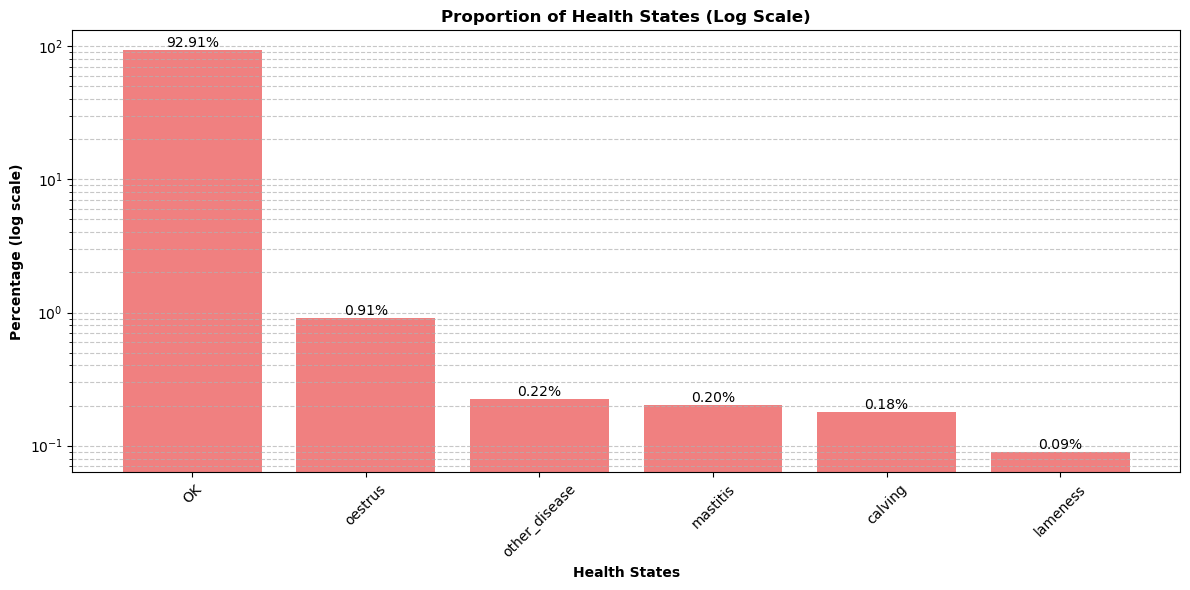

In [ ]:
health_states = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK']

df_health = df[health_states]
health_counts = df_health.sum().sort_values(ascending=False)
total = len(df)
health_percent = (health_counts / total) * 100

safe_health_percent = health_percent.copy()
safe_health_percent[safe_health_percent == 0] = 0.01

plt.figure(figsize=(12, 6))
bars = plt.bar(safe_health_percent.index, safe_health_percent.values, color='lightcoral')

for i, bar in enumerate(bars):
    original = health_percent.values[i]
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{original:.2f}%', ha='center', va='bottom')

plt.yscale('log')
plt.title('Proportion of Health States (Log Scale)', fontweight='bold')
plt.xlabel('Health States', fontweight='bold')
plt.ylabel('Percentage (log scale)', fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7, which='both')
plt.tight_layout()
plt.show()

In [ ]:
df['date'] = pd.to_datetime(df['date'])

obs_counts = df.groupby(['cow', 'date']).size().reset_index(name='hour_count')

missing_obs = obs_counts[obs_counts['hour_count'] < 24]

# plt.figure(figsize=(12, 6))
# missing_obs.groupby('cow')['hour_count'].apply(lambda x: (24 - x).sum()).sort_values(ascending=False).plot(kind='bar')
# plt.title("Total Missing Hours per Cow (only cows with missing 24h records)")
# plt.xlabel("Cow ID")
# plt.ylabel("Total Missing Hours")
# plt.tight_layout()
# plt.show()

Investigate the correlation between the "OK" label and other health states.


Check if, in the dataset, when a cow is labeled as OK, there is any other health label equal to 1.


In [ ]:
health_labels = [
    'oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'accidents', 'disturbance',
    'mixing', 'management_changes'
]

correlations = df[health_labels + ['OK']].corr()['OK'].drop('OK')

ok_and_pathology_overlap = df[(df['OK'] == 1) & (df[health_labels].sum(axis=1) > 0)]


print(correlations)
print(ok_and_pathology_overlap)


oestrus              -0.347652
calving              -0.153000
lameness             -0.108139
mastitis             -0.162299
other_disease        -0.171098
accidents                  NaN
disturbance          -0.720787
mixing               -0.462316
management_changes         NaN
Name: OK, dtype: float64
Empty DataFrame
Columns: [cow, date, hour, IN_ALLEYS, REST, EAT, ACTIVITY_LEVEL, oestrus, calving, lameness, mastitis, LPS, acidosis, other_disease, accidents, disturbance, mixing, management_changes, OK]
Index: []


Manual check

In [ ]:
# Liste des colonnes représentant les états de santé
health_labels = [
    'oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'accidents',
]

# Filtrer les lignes où OK == 1 et au moins un état de santé est aussi à 1
violations = df[(df['OK'] == 1) & (df[health_labels].sum(axis=1) > 0)]

# Vérification et affichage
if violations.empty:
    print("✅ Aucun cas trouvé où OK == 1 et un état de santé est aussi à 1. Tout est cohérent.")
else:
    print("⚠️ Des cas incohérents ont été trouvés ! Voici les lignes concernées :")
    print(violations)


✅ Aucun cas trouvé où OK == 1 et un état de santé est aussi à 1. Tout est cohérent.


## . Data Preprocessing


Step 2: Perform another cleaning by keeping only records with more that 18 samples


In [ ]:
df_cleaned =df.copy()
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])

hourly_counts = df_cleaned.groupby(['cow', 'date']).size().reset_index(name='hour_count')


In [ ]:
# Identify 24h records by observation count

records_more_than_18_obs = hourly_counts[hourly_counts['hour_count'] > 18]
records_12_to_18_obs = hourly_counts[(hourly_counts['hour_count'] >= 12) & (hourly_counts['hour_count'] < 18)]
records_less_than_12_obs = hourly_counts[hourly_counts['hour_count'] < 12]

# Merge to filter full rows from original dataframe
df_more_than_18_obs = df_cleaned.merge(records_more_than_18_obs[['cow', 'date']], on=['cow', 'date'])
df_12_to_18_obs = df_cleaned.merge(records_12_to_18_obs[['cow', 'date']], on=['cow', 'date'])
df_less_than_12_obs = df_cleaned.merge(records_less_than_12_obs[['cow', 'date']], on=['cow', 'date'])

# Drop the records with less than 12 observations from the main dataset
df_filtered = df_cleaned[~df_cleaned.set_index(['cow', 'date']).index.isin(df_less_than_12_obs.set_index(['cow', 'date']).index)]

# Print dataset shapes
print("Original dataset shape:", df.shape)
print("After filtering (<12 obs removed):", df_filtered.shape)
print("Deleted rows (<12 obs):", df_less_than_12_obs.shape)
print("Filtered dataset (>18 obs):", df_more_than_18_obs.shape)
print("Filtered dataset (12–18 obs):", df_12_to_18_obs.shape)

Original dataset shape: (107665, 19)
After filtering (<12 obs removed): (107665, 19)
Deleted rows (<12 obs): (0, 19)
Filtered dataset (>18 obs): (106269, 19)
Filtered dataset (12–18 obs): (1396, 19)


In [ ]:
# Save datasets
df_more_than_18_obs.to_csv(r"filtered_dataset_more_than_18_obs.csv", index=False)

In [ ]:
# Count number of unique (cow, date) pairs and unique cows for df_more_than_18_days
num_days_more_than_18 = df_more_than_18_obs[['cow', 'date']].drop_duplicates().shape[0]
num_cows_more_than_18 = df_more_than_18_obs['cow'].nunique()

# Count number of unique (cow, date) pairs and unique cows for df_12_to_18_days
num_days_12_to_18 = df_12_to_18_obs[['cow', 'date']].drop_duplicates().shape[0]
num_cows_12_to_18 = df_12_to_18_obs['cow'].nunique()

# Print results
print("More than 18 days:")
print(f"Number of unique days: {num_days_more_than_18}")
print(f"Number of unique cows: {num_cows_more_than_18}")

print("\n12 to 18 days:")
print(f"Number of unique days: {num_days_12_to_18}")
print(f"Number of unique cows: {num_cows_12_to_18}")


More than 18 days:
Number of unique days: 4434
Number of unique cows: 28

12 to 18 days:
Number of unique days: 97
Number of unique cows: 28


Total gaps found: 119


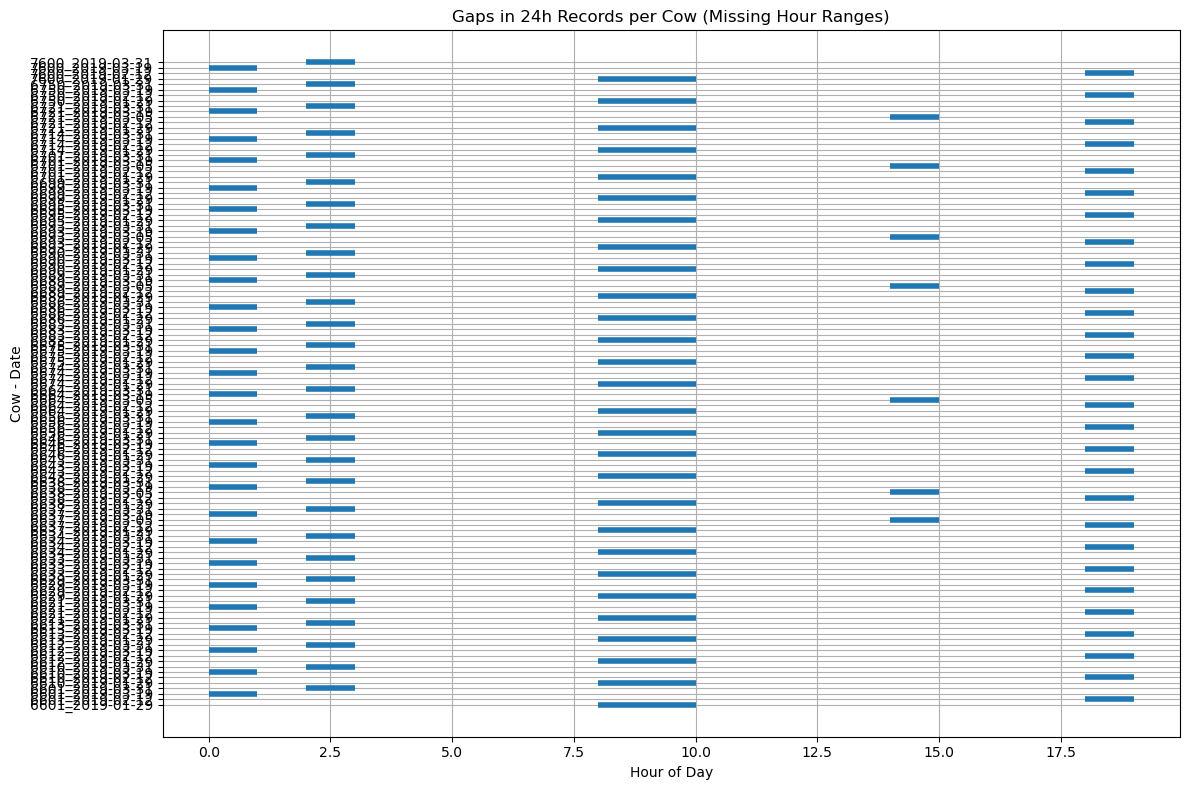

In [ ]:
df = pd.read_csv(r"filtered_dataset_more_than_18_obs.csv")


# Ensure correct types
df['hour'] = df['hour'].astype(int)
df['date'] = pd.to_datetime(df['date'])

# Identify full range of hours
full_hours = list(range(24))

# Keep only cows that have missing hours
hour_counts = df.groupby(['cow', 'date'])['hour'].nunique().reset_index(name='hour_count')
incomplete_days = hour_counts[hour_counts['hour_count'] < 24]
df_incomplete = df.merge(incomplete_days[['cow', 'date']], on=['cow', 'date'])

# Build gap data
gap_data = []
for (cow, date), group in df_incomplete.groupby(['cow', 'date']):
    observed_hours = sorted(group['hour'].unique())
    missing_hours = sorted(set(full_hours) - set(observed_hours))
    gaps = []
    if missing_hours:
        start = missing_hours[0]
        for i in range(1, len(missing_hours)):
            if missing_hours[i] != missing_hours[i-1] + 1:
                gaps.append((start, missing_hours[i-1]))
                start = missing_hours[i]
        gaps.append((start, missing_hours[-1]))
        for g_start, g_end in gaps:
            gap_data.append({
                'cow': cow,
                'date': date,
                'start_hour': g_start,
                'end_hour': g_end
            })

gap_df = pd.DataFrame(gap_data)

# Plot gaps
print(f"Total gaps found: {len(gap_df)}")
if len(gap_df):
    plt.figure(figsize=(12, 8))
    for cow in gap_df['cow'].unique():
        cow_data = gap_df[gap_df['cow'] == cow]
        for i, row in cow_data.iterrows():
            plt.hlines(y=f"{row['cow']}_{row['date'].date()}", xmin=row['start_hour'], xmax=row['end_hour']+1, linewidth=4)

    plt.xlabel('Hour of Day')
    plt.ylabel('Cow - Date')
    plt.title('Gaps in 24h Records per Cow (Missing Hour Ranges)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
df.head(24)

cow       date  hour  IN_ALLEYS      REST       EAT  ACTIVITY_LEVEL  \
0   6601 2018-10-26     0    903.094   971.432  1722.904       644.68536   
1   6601 2018-10-26     1     11.277  3588.717     0.000      -823.60059   
2   6601 2018-10-26     2    367.232  3232.762     0.000      -684.77814   
3   6601 2018-10-26     3     25.598  3574.396     0.000      -818.01540   
4   6601 2018-10-26     4     28.659  3571.335     0.000      -816.82161   
5   6601 2018-10-26     5    167.361  3432.456     0.177      -762.61278   
6   6601 2018-10-26     6   2232.539   485.334   882.121       616.07024   
7   6601 2018-10-26     7   3445.364    23.007   131.623       601.24829   
8   6601 2018-10-26     8   3229.792   306.750    63.452       472.86406   
9   6601 2018-10-26     9   2281.611   846.084   472.299       368.82402   
10  6601 2018-10-26    10   1064.929   197.206  2337.859      1106.93204   
11  6601 2018-10-26    11   1235.313   102.471  2262.210      1124.20995   
12  6601 2018-10-26    12   2523.211   155.482   865.378       731.41166   
13  6601 2018-10-26    13    702.903  2491.896   405.195      -290.48970   
14  6601 2018-10-26    14    901.521  1322.041  1376.432       418.27537   
15  6601 2018-10-26    15     36.456  3563.538     0.000      -813.78078   
16  6601 2018-10-26    16   1970.494   547.381  1082.119       643.87139   
17  6601 2018-10-26    17    867.906  1871.936   860.152        69.58352   
18  6601 2018-10-26    18    191.363  3058.350   350.281      -525.68440   
19  6601 2018-10-26    19    988.680   337.962  2273.352      1035.26538   
20  6601 2018-10-26    20     85.672  3514.322     0.000      -794.58654   
21  6601 2018-10-26    21   1093.711  1075.660  1430.623       528.45362   
22  6601 2018-10-26    22    369.539  3127.309   103.146      -616.83351   
23  6601 2018-10-26    23     35.875  3564.119     0.000      -814.00737   

    oestrus  calving  lameness  mastitis  LPS  acidosis  other_disease  \
0         0        0         0         0    0       NaN              0   
1         0        0         0         0    0       NaN              0   
2         0        0         0         0    0       NaN              0   
3         0        0         0         0    0       NaN              0   
4         0        0         0         0    0       NaN              0   
5         0        0         0         0    0       NaN              0   
6         0        0         0         0    0       NaN              0   
7         0        0         0         0    0       NaN              0   
8         0        0         0         0    0       NaN              0   
9         0        0         0         0    0       NaN              0   
10        0        0         0         0    0       NaN              0   
11        0        0         0         0    0       NaN              0   
12        0        0         0         0    0       NaN              0   
13        0        0         0         0    0       NaN              0   
14        0        0         0         0    0       NaN              0   
15        0        0         0         0    0       NaN              0   
16        0        0         0         0    0       NaN              0   
17        0        0         0         0    0       NaN              0   
18        0        0         0         0    0       NaN              0   
19        0        0         0         0    0       NaN              0   
20        0        0         0         0    0       NaN              0   
21        0        0         0         0    0       NaN              0   
22        0        0         0         0    0       NaN              0   
23        0        0         0         0    0       NaN              0   

    accidents  disturbance  mixing  management_changes  OK  
0           0            0       0                   0   1  
1           0            0       0                   0   1  
2           0            0       0                   0   1  
3        

Step 1: Perform initial cleaning by keeping only physiological classes:


Retain: mastitis, lameness, oestrus, calving, other_diseases, OK.


Remove: management changes, mixing, disturbance, accidents, LPS, acidosis.

In [ ]:
# houni khedmet lamya o roua mtaa el KNN imputation
df = pd.read_csv(r"filtered_dataset_more_than_18_obs.csv")

# Clean column names
df.columns = df.columns.str.strip()

# Convert the 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

# Sort the data by cow and date
df = df.sort_values(by=['cow', 'date'])

# Function to get durations for a specific health state
def get_health_state_durations(df, health_state_column):
    durations = []

    # For each cow
    for cow_id, group in df.groupby('cow'):
        group = group.sort_values('date').reset_index(drop=True)

        current_state = False
        start_date = None
        prev_date = None

        for i, row in group.iterrows():
            if row[health_state_column] == 1:
                if not current_state:
                    # Start new period
                    current_state = True
                    start_date = row['date']
                elif prev_date is not None and (row['date'] - prev_date).days > 1:
                    # Gap detected → close previous period
                    end_date = prev_date
                    duration = (end_date - start_date).days + 1
                    durations.append({
                        'cow': cow_id,
                        'health_state': health_state_column,
                        'start_date': start_date,
                        'end_date': end_date,
                        'duration_days': duration
                    })
                    # Start new period
                    start_date = row['date']
            else:
                if current_state:
                    end_date = prev_date if prev_date is not None else row['date']
                    duration = (end_date - start_date).days + 1
                    durations.append({
                        'cow': cow_id,
                        'health_state': health_state_column,
                        'start_date': start_date,
                        'end_date': end_date,
                        'duration_days': duration
                    })
                    current_state = False
                    start_date = None

            prev_date = row['date']

        # Handle case where last rows are 1s
        if current_state:
            end_date = prev_date
            duration = (end_date - start_date).days + 1
            durations.append({
                'cow': cow_id,
                'health_state': health_state_column,
                'start_date': start_date,
                'end_date': end_date,
                'duration_days': duration
            })

    return pd.DataFrame(durations)

# Dictionaries to store durations
state_durations = {}
durations_min_max = {}

# Compute durations for each health state
for state in health_states:
    durations_df = get_health_state_durations(df, state)
    state_durations[state] = durations_df

    if not durations_df.empty:
        min_duration = durations_df['duration_days'].min()
        max_duration = durations_df['duration_days'].max()
        durations_min_max[state] = {'min_days': min_duration, 'max_days': max_duration}
    else:
        durations_min_max[state] = {'min_days': None, 'max_days': None}

# Display results
for state, durations in durations_min_max.items():
    min_days = durations['min_days']
    max_days = durations['max_days']

    if min_days is None or max_days is None:
        print(f"No data available for \"{state}\".")
    elif min_days == max_days:
        print(f"{state.capitalize()} lasts {min_days} day{'s' if min_days > 1 else ''}.")
    else:
        print(f"{state.capitalize()} lasts between {min_days} and {max_days} days.")

Oestrus lasts 1 day.
Calving lasts 1 day.
Lameness lasts 1 day.
Mastitis lasts between 2 and 3 days.
Other_disease lasts 1 day.
Ok lasts between 1 and 44 days.


nbadlou el code bel bagra ywali ykharej tableau felekher kol bargra kadech yokaed kol event when happened

In [ ]:

# Step 1: Identify event columns dynamically
non_event_cols = ['cow', 'date', 'hour', 'IN_ALLEYS','REST','EAT','ACTIVITY_LEVEL', 'OK']
event_cols = [col for col in df.columns if col not in non_event_cols]

# Step 2: Aggregate daily events
daily = df.groupby(['cow', 'date'])[event_cols].max().reset_index()
daily['date'] = pd.to_datetime(daily['date'])

# Step 3: Create full cow x day table
all_dates = pd.date_range(daily['date'].min() - timedelta(days=7), daily['date'].max() + timedelta(days=7))
cows = daily['cow'].unique()
full_daily = pd.MultiIndex.from_product([cows, all_dates], names=['cow', 'date']).to_frame(index=False)

# Merge and fill missing
full_daily = full_daily.merge(daily, on=['cow', 'date'], how='left')
full_daily[event_cols] = full_daily[event_cols].fillna(0)

# Add LABEL and default OK
full_daily['LABEL'] = 'control'
full_daily['OK'] = 1

# Step 4: Spread rules
spread_rules = {
    'oestrus': {'before': 1, 'after': 1},
    'calving': {'before': 2, 'after': 1},
    'lameness': {'before': 2, 'after': 1},
    'mastitis': {'before': 2, 'after': 1},
    'acidosis': {'before': 2, 'after': 1},
    'LPS': {'before': 2, 'after': 1},
    'other_disease': {'before': 2, 'after': 1},
    'accidents': {'before': 2, 'after': 1},
    'disturbance': {'before': 0, 'after': 0},
    'mixing': {'before': 0, 'after': 0},
    'management_changes': {'before': 0, 'after': 0},
}

for cond in event_cols:
    if cond not in spread_rules:
        continue
    sub = full_daily[full_daily[cond] == 1][['cow', 'date']].sort_values(['cow', 'date'])
    for cow_id in sub['cow'].unique():
        cow_days = sub[sub['cow'] == cow_id]['date'].sort_values()
        episode = []
        prev_day = None
        for day in cow_days:
            if prev_day is None or (day - prev_day).days > 1:
                if episode:
                    min_day = min(episode)
                    max_day = max(episode)
                    spread = spread_rules[cond]
                    spread_days = pd.date_range(min_day - timedelta(days=spread['before']), max_day + timedelta(days=spread['after']))
                    mask = (full_daily['cow'] == cow_id) & (full_daily['date'].isin(spread_days))
                    full_daily.loc[mask, cond] = 1
                    full_daily.loc[mask & (full_daily['LABEL'] == 'control'), 'LABEL'] = cond
                    full_daily.loc[mask, 'OK'] = 0
                episode = [day]
            else:
                episode.append(day)
            prev_day = day
        if episode:
            min_day = min(episode)
            max_day = max(episode)
            spread = spread_rules[cond]
            spread_days = pd.date_range(min_day - timedelta(days=spread['before']), max_day + timedelta(days=spread['after']))
            mask = (full_daily['cow'] == cow_id) & (full_daily['date'].isin(spread_days))
            full_daily.loc[mask, cond] = 1
            full_daily.loc[mask & (full_daily['LABEL'] == 'control'), 'LABEL'] = cond
            full_daily.loc[mask, 'OK'] = 0

# Step 5: Prepare df before merging (drop event columns to avoid conflict)
df['date'] = pd.to_datetime(df['date'])
df = df.drop(columns=event_cols + ['OK'], errors='ignore')  # <<< DROP these before merging

# Merge cleanly
final = df.merge(full_daily[['cow', 'date', 'LABEL'] + event_cols + ['OK']], on=['cow', 'date'], how='left')

# Step 6: If a day was labeled with an event, update hourly events if missing
for cond in event_cols:
    final.loc[(final['LABEL'] == cond) & (final[cond] == 0), cond] = 1

final.to_csv(r"labelled&aligned_dataset.csv", index=False)

final.head(24)

cow       date  hour  IN_ALLEYS      REST       EAT  ACTIVITY_LEVEL  \
0   6601 2018-10-26     0    903.094   971.432  1722.904       644.68536   
1   6601 2018-10-26     1     11.277  3588.717     0.000      -823.60059   
2   6601 2018-10-26     2    367.232  3232.762     0.000      -684.77814   
3   6601 2018-10-26     3     25.598  3574.396     0.000      -818.01540   
4   6601 2018-10-26     4     28.659  3571.335     0.000      -816.82161   
5   6601 2018-10-26     5    167.361  3432.456     0.177      -762.61278   
6   6601 2018-10-26     6   2232.539   485.334   882.121       616.07024   
7   6601 2018-10-26     7   3445.364    23.007   131.623       601.24829   
8   6601 2018-10-26     8   3229.792   306.750    63.452       472.86406   
9   6601 2018-10-26     9   2281.611   846.084   472.299       368.82402   
10  6601 2018-10-26    10   1064.929   197.206  2337.859      1106.93204   
11  6601 2018-10-26    11   1235.313   102.471  2262.210      1124.20995   
12  6601 2018-10-26    12   2523.211   155.482   865.378       731.41166   
13  6601 2018-10-26    13    702.903  2491.896   405.195      -290.48970   
14  6601 2018-10-26    14    901.521  1322.041  1376.432       418.27537   
15  6601 2018-10-26    15     36.456  3563.538     0.000      -813.78078   
16  6601 2018-10-26    16   1970.494   547.381  1082.119       643.87139   
17  6601 2018-10-26    17    867.906  1871.936   860.152        69.58352   
18  6601 2018-10-26    18    191.363  3058.350   350.281      -525.68440   
19  6601 2018-10-26    19    988.680   337.962  2273.352      1035.26538   
20  6601 2018-10-26    20     85.672  3514.322     0.000      -794.58654   
21  6601 2018-10-26    21   1093.711  1075.660  1430.623       528.45362   
22  6601 2018-10-26    22    369.539  3127.309   103.146      -616.83351   
23  6601 2018-10-26    23     35.875  3564.119     0.000      -814.00737   

      LABEL  oestrus  calving  lameness  mastitis  LPS  acidosis  \
0   control      0.0      0.0       0.0       0.0  0.0       0.0   
1   control      0.0      0.0       0.0       0.0  0.0       0.0   
2   control      0.0      0.0       0.0       0.0  0.0       0.0   
3   control      0.0      0.0       0.0       0.0  0.0       0.0   
4   control      0.0      0.0       0.0       0.0  0.0       0.0   
5   control      0.0      0.0       0.0       0.0  0.0       0.0   
6   control      0.0      0.0       0.0       0.0  0.0       0.0   
7   control      0.0      0.0       0.0       0.0  0.0       0.0   
8   control      0.0      0.0       0.0       0.0  0.0       0.0   
9   control      0.0      0.0       0.0       0.0  0.0       0.0   
10  control      0.0      0.0       0.0       0.0  0.0       0.0   
11  control      0.0      0.0       0.0       0.0  0.0       0.0   
12  control      0.0      0.0       0.0       0.0  0.0       0.0   
13  control      0.0      0.0       0.0       0.0  0.0       0.0   
14  control      0.0      0.0       0.0       0.0  0.0       0.0   
15  control      0.0      0.0       0.0       0.0  0.0       0.0   
16  control      0.0      0.0       0.0       0.0  0.0       0.0   
17  control      0.0      0.0       0.0       0.0  0.0       0.0   
18  control      0.0      0.0       0.0       0.0  0.0       0.0   
19  control      0.0      0.0       0.0       0.0  0.0       0.0   
20  control      0.0      0.0       0.0       0.0  0.0       0.0   
21  control      0.0      0.0       0.0       0.0  0.0       0.0   
22  control      0.0      0.0       0.0       0.0  0.0       0.0   
23  control      0.0      0.0       0.0       0.0  0.0       0.0   

    other_disease  accidents  disturbance  mixing  management_changes  OK  
0             0.0        0.0          0.0     0.0                 0.0   1  
1             0.0        0.0          0.0     0.0                 0.0   1  
2             0.0        0.0          0.0     0.0                 0.0   1  
3             0.0        0.0          0.0     0.0                 0.0   1  
4             0.0      

In [ ]:
# Step 5: Visual check of consecutive days labeling

# Choose a cow to inspect
#cow_to_check = final['cow'].sample(1).iloc[0]  # or manually set, e.g., cow_to_check = 10127
cow_to_check = 44432
# Filter that cow
cow_data = final[final['cow'] == cow_to_check][['cow', 'date', 'hour', 'LABEL']]

# Group by date (daily view)
daily_view = cow_data.groupby(['cow', 'date'])['LABEL'].agg(lambda x: x.mode()[0]).reset_index()

# Display consecutive days
print(f"Consecutive days labeling for Cow {cow_to_check}:")
display(daily_view.sort_values('date'))

Consecutive days labeling for Cow 44432:


Empty DataFrame
Columns: [cow, date, LABEL]
Index: []

**Investigating before imputation**

In [ ]:
import pandas as pd

# Step 0: Load the dataset
file_path = r"labelled&aligned_dataset.csv"
df = pd.read_csv(file_path)

# Step 1: Define useful and unwanted classes
useful_classes = ['mastitis', 'lameness', 'oestrus', 'calving', 'other_disease', 'OK']
removed_classes = ['management_changes', 'mixing', 'disturbance', 'accidents', 'LPS', 'acidosis']

# Step 2: Tag samples based on unwanted classes
df['had_removed_class'] = df[removed_classes].max(axis=1)  # 1 if any unwanted class was active

# Step 3: After dropping unwanted classes, check if any useful class remains
df['has_useful_class'] = df[useful_classes].max(axis=1)  # 1 if any useful class active

# Step 4: Identify rows needing reassignment
rows_to_reassign = df[(df['had_removed_class'] == 1) & (df['has_useful_class'] == 0)]

# Step 5: Summary statistics
total_rows = len(df)
total_to_reassign = len(rows_to_reassign)
proportion = total_to_reassign / total_rows * 100

print(f"Total rows in dataset: {total_rows}")
print(f"Rows needing reassignment: {total_to_reassign}")
print(f"Proportion needing reassignment: {proportion:.2f}%")


Total rows in dataset: 106269
Rows needing reassignment: 7361
Proportion needing reassignment: 6.93%


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Step 2: Detect samples related to removed classes
df['needs_replacement'] = df[removed_classes].max(axis=1)  # 1 if any removed class is active

# Step 3: Create the physiological label
# Priority: if multiple physiological labels active, pick the first in useful_classes
def get_physio_label(row):
    for cond in useful_classes:
        if row[cond] == 1:
            return cond
    return None

df['physio_label'] = df.apply(get_physio_label, axis=1)

# Step 4: Split into clean vs. to-replace
to_replace = df[(df['needs_replacement'] == 1) & (df['physio_label'].isnull())].copy()
clean_physio = df[(df['needs_replacement'] == 0) & (df['physio_label'].notnull())].copy()

In [ ]:
behavior_features = ['IN_ALLEYS', 'REST', 'EAT', 'ACTIVITY_LEVEL']

# Only disease cases for training
disease_classes = ['mastitis', 'lameness', 'oestrus', 'calving', 'other_disease','OK']

train_disease = clean_physio[clean_physio['physio_label'].isin(disease_classes)]

X_train = train_disease[behavior_features]
y_train = train_disease['physio_label']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# with KNN

In [ ]:

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Step 6: Predict missing labels
X_missing = scaler.transform(to_replace[behavior_features])
predicted_labels = knn.predict(X_missing)

# Assign the new labels
to_replace['physio_label'] = predicted_labels

# Step 6.1: Analyze reassignment
reassignment_summary = pd.Series(predicted_labels).value_counts().reset_index()
reassignment_summary.columns = ['Physiological_Class', 'Number_of_Reassigned_Samples']

print(reassignment_summary)

  Physiological_Class  Number_of_Reassigned_Samples
0                  OK                          7361


In [ ]:
# Step 7: Merge back
# For each predicted label, mark the corresponding event column to 1
for cond in useful_classes:
    to_replace.loc[to_replace['physio_label'] == cond, cond] = 1

# Clean removed columns
df_final = pd.concat([clean_physio, to_replace], axis=0)
df_final = df_final.drop(columns=removed_classes + ['needs_replacement'])

# Optional: reorder if needed
df_final = df_final.sort_values(by=['cow', 'date', 'hour']).reset_index(drop=True)


In [ ]:
# Step 8: Save the cleaned and reconstructed dataset
df_final.to_csv('final2_cleaned_and_reassigned_dataset.csv', index=False)

# Show sample
df_final[['cow', 'date', 'hour', 'physio_label']].sample(10)

cow        date  hour physio_label
21144   6629  2019-01-03     1           OK
105541  7600  2019-04-06    16           OK
11997   6612  2019-04-14    12           OK
33473   6637  2019-01-16     9           OK
46330   6646  2019-03-25    23           OK
46065   6646  2019-03-13    21           OK
21167   6629  2019-01-04     0           OK
49798   6656  2019-03-01    15           OK
64247   6683  2019-02-05    12           OK
69933   6689  2018-11-08    18           OK

**Imputation using GAN**

In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 10
feature_dim = X_train_scaled.shape[1]

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, feature_dim)
        )
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(feature_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.001)
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.001)

# ===== Step 3: Train GAN =====
real_data = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
batch_size = 64
epochs = 1000

for epoch in range(epochs):
    # Train discriminator
    z = torch.randn(real_data.size(0), latent_dim).to(device)
    fake_data = G(z)

    real_labels = torch.ones(real_data.size(0), 1).to(device)
    fake_labels = torch.zeros(real_data.size(0), 1).to(device)

    d_loss_real = criterion(D(real_data), real_labels)
    d_loss_fake = criterion(D(fake_data.detach()), fake_labels)
    d_loss = d_loss_real + d_loss_fake

    D.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    # Train generator
    z = torch.randn(real_data.size(0), latent_dim).to(device)
    fake_data = G(z)
    g_loss = criterion(D(fake_data), real_labels)

    G.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# ===== Step 4: Generate synthetic features for missing samples =====
num_missing = len(to_replace)
z = torch.randn(num_missing, latent_dim).to(device)
generated_features = G(z).detach().cpu().numpy()
generated_features = np.clip(generated_features, -3, 3)  # Optionnel

# ===== Step 5: Classify generated samples =====

generated_labels = np.random.choice(disease_classes, size=num_missing)

to_replace[behavior_features] = scaler.inverse_transform(generated_features)
to_replace['physio_label'] = generated_labels

# ===== Step 6: Analyse & merge =====
reassignment_summary = pd.Series(generated_labels).value_counts().reset_index()
reassignment_summary.columns = ['Physiological_Class', 'Number_of_Reassigned_Samples']
print(reassignment_summary)

df_final = pd.concat([clean_physio, to_replace], axis=0)
df_final = df_final.drop(columns=removed_classes + ['needs_replacement'])
df_final = df_final.sort_values(by=['cow', 'date', 'hour']).reset_index(drop=True)



Epoch 0, D Loss: 1.4364, G Loss: 0.5850
Epoch 200, D Loss: 1.1106, G Loss: 0.7527
Epoch 400, D Loss: 1.0221, G Loss: 1.0450
Epoch 600, D Loss: 1.3779, G Loss: 0.7863
Epoch 800, D Loss: 1.6758, G Loss: 0.7251
  Physiological_Class  Number_of_Reassigned_Samples
0            mastitis                          1305
1       other_disease                          1243
2             calving                          1228
3            lameness                          1223
4             oestrus                          1209
5                  OK                          1153


In [ ]:
df_final.to_csv(r'GAN_cleaned_and_reassigned_dataset.csv', index=False)
print(df_final[['cow', 'date', 'hour', 'physio_label']].sample(10))

         cow        date  hour physio_label
64802   6683  2019-02-28    16     lameness
74025   6690  2018-11-12    12           OK
105774  7600  2019-04-16     9           OK
65402   6683  2019-03-26    17           OK
62050   6675  2019-04-08    21           OK
78871   6693  2018-12-31    15           OK
57469   6674  2019-03-15    17           OK
6471    6610  2019-02-09    22           OK
8859    6612  2018-11-28    13           OK
36109   6638  2018-12-04    11           OK


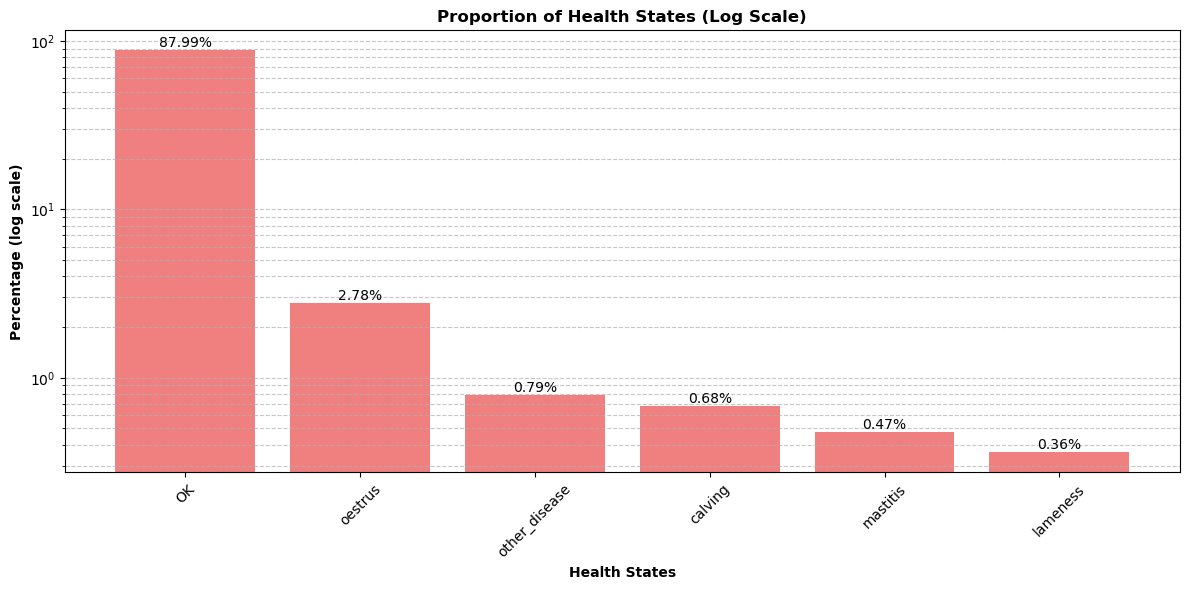

In [ ]:
health_states = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK']

df_health = df[health_states]
health_counts = df_health.sum().sort_values(ascending=False)
total = len(df)
health_percent = (health_counts / total) * 100

safe_health_percent = health_percent.copy()
safe_health_percent[safe_health_percent == 0] = 0.01

plt.figure(figsize=(12, 6))
bars = plt.bar(safe_health_percent.index, safe_health_percent.values, color='lightcoral')

for i, bar in enumerate(bars):
    original = health_percent.values[i]
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{original:.2f}%', ha='center', va='bottom')

plt.yscale('log')
plt.title('Proportion of Health States (Log Scale)', fontweight='bold')
plt.xlabel('Health States', fontweight='bold')
plt.ylabel('Percentage (log scale)', fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7, which='both')
plt.tight_layout()
plt.show()

# one hour shifting process

In [ ]:
# Parameters
window_size_hours = 24
min_valid_hours = 18
shift_hours = 1
condition_columns = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease']

# Adjust hour 24 to 00 and increment the date
df['adjusted_date'] = df['date']
df['adjusted_hour'] = df['hour']
df.loc[df['hour'] == 24, 'adjusted_date'] = pd.to_datetime(df.loc[df['hour'] == 24, 'date']) + timedelta(days=1)
df.loc[df['hour'] == 24, 'adjusted_hour'] = 0

# Ensure datetime format
df['adjusted_date'] = pd.to_datetime(df['adjusted_date'])

# Combine adjusted_date and adjusted_hour into a timestamp
df['timestamp'] = pd.to_datetime(df['adjusted_date'].dt.strftime('%Y-%m-%d') + ' ' + df['adjusted_hour'].astype(str) + ':00:00')
df = df.sort_values(['cow', 'timestamp'])

# Group by cow
grouped = df.groupby('cow')
shifted_windows = []

for cow_id, group in grouped:
    timestamps = group['timestamp'].tolist()
    group = group.set_index('timestamp')  # Index by timestamp for easy lookup

    print(f"\n🐄 Processing cow {cow_id} with {len(timestamps)} records...")

    for start_time in timestamps:
        end_time = start_time + timedelta(hours=window_size_hours)
        collected_hours = []
        current_time = start_time
        previous_date = current_time.date()

        while current_time < end_time:
            if current_time in group.index:
                current_date = current_time.date()

                # Stop if there's a day gap
                if (current_date - previous_date).days > 1:
                    print(f"🛑 Stopping at {current_time} due to missing day.")
                    break

                collected_hours.append(group.loc[current_time]['ACTIVITY_LEVEL'])
                previous_date = current_date
                current_time += timedelta(hours=1)
            else:
                # Hour is missing, skip it but advance time
                print(f"⚠️  Missing hour at {current_time}, skipping.")
                current_date = current_time.date()

                if (current_date - previous_date).days > 0:
                    print(f"🛑 Stopping at {current_time} due to day gap after missing hour.")
                    break

                previous_date = current_date
                current_time += timedelta(hours=1)

        if len(collected_hours) >= min_valid_hours:
            end_effective = start_time + timedelta(hours=len(collected_hours) - 1)

            # Get condition values across the window
            condition_window = group.loc[start_time:end_effective]
            condition_counts = condition_window[condition_columns].sum()

            # Prepare final label dictionary: all 0s initially
            final_conditions = {col: 0 for col in condition_columns}

            if (condition_counts > 0).any():
                most_frequent_condition = condition_counts.idxmax()
                final_conditions[most_frequent_condition] = 1
                final_conditions['OK'] = 0
            else:
                final_conditions['OK'] = 1


            shifted_windows.append({
                'cow': cow_id,
                'start_time': start_time,
                'end_time': end_effective,
                'duration_hours': len(collected_hours),
                'activity_window': collected_hours,
                **final_conditions
            })

            print(f"✅ Window for cow {cow_id} → {most_frequent_condition if (condition_counts > 0).any() else 'healthy'}")
        else:
            print(f"❌ Discarded window for cow {cow_id} from {start_time}: only {len(collected_hours)} valid hours.")

# Final DataFrame
shifted_df = pd.DataFrame(shifted_windows)

print("\n✅ DONE.")
print(f"Total valid windows collected: {len(shifted_df)}")
display(shifted_df.head())


🐄 Processing cow 6601 with 4027 records...
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → healthy
✅ Window for cow 6601 → heal

cow          start_time            end_time  duration_hours  \
0  6601 2018-10-26 00:00:00 2018-10-26 23:00:00              24   
1  6601 2018-10-26 01:00:00 2018-10-27 00:00:00              24   
2  6601 2018-10-26 02:00:00 2018-10-27 01:00:00              24   
3  6601 2018-10-26 03:00:00 2018-10-27 02:00:00              24   
4  6601 2018-10-26 04:00:00 2018-10-27 03:00:00              24   

                                     activity_window  oestrus  calving  \
0  [644.68536, -823.60059, -684.77814, -818.0154,...        0        0   
1  [-823.60059, -684.77814, -818.0154, -816.82161...        0        0   
2  [-684.77814, -818.0154, -816.82161, -762.61278...        0        0   
3  [-818.0154, -816.82161, -762.61278, 616.07024,...        0        0   
4  [-816.82161, -762.61278, 616.07024, 601.24829,...        0        0   

   lameness  mastitis  other_disease  OK  
0         0         0              0   1  
1         0         0              0   1  
2         0         0              0   1  
3         0         0              0   1  
4         0         0              0   1

In [ ]:
output_csv_path = "OneHourShift.csv"
shifted_df.to_csv(output_csv_path, index=False)
print(f"CSV file saved to {output_csv_path}")

CSV file saved to OneHourShift.csv


# New dataset with one hour shift and the new 32 features

In [ ]:
# ----------------------------
# 1. Feature Calculation Logic
# ----------------------------

def calculate_all_features(activity_windows):
    features = []

    for window in activity_windows:
        try:
            window = np.array(window)
            feature_dict = {}

            # Time-Domain Features (1–17)
            feature_dict['Minimum'] = np.min(window)
            feature_dict['Maximum'] = np.max(window)
            feature_dict['Mean'] = np.mean(window)
            feature_dict['RMS'] = np.sqrt(np.mean(np.square(window)))
            feature_dict['STD'] = np.std(window)

            # 6-hour windows
            six_h_windows = [window[i*6:(i+1)*6] for i in range(4)]
            stds_6h = [np.std(w) for w in six_h_windows]
            means_6h = [np.mean(w) for w in six_h_windows]
            feature_dict['MeanSTD6h'] = np.mean(stds_6h)
            feature_dict['STDMean6h'] = np.std(means_6h)

            diffs = np.diff(window)
            feature_dict['STDSD'] = np.std(diffs)


            # RMSSD (successive differences)
            feature_dict['RMSSD'] = np.sqrt(np.mean(np.square(diffs)))

            # Distribution features
            feature_dict['Mode'] = stats.mode(window, keepdims=True)[0][0] if len(window) > 0 else np.nan
            feature_dict['Q10'] = np.percentile(window, 10)
            feature_dict['Q90'] = np.percentile(window, 90)
            feature_dict['Q25'] = np.percentile(window, 25)
            feature_dict['Q50'] = np.percentile(window, 50)
            feature_dict['Q75'] = np.percentile(window, 75)
            feature_dict['Skewness'] = stats.skew(window)
            feature_dict['Kurtosis'] = stats.kurtosis(window)

            # Autocorrelation (lags 1 to 11)
            for lag in range(1, 12):
                if len(window) > lag:
                    corr = np.corrcoef(window[:-lag], window[lag:])[0, 1]
                else:
                    corr = np.nan
                feature_dict[f'Autocorr{lag}'] = corr

            # Frequency-Domain Features (harmonics)
            fft_result = np.abs(fft.fft(window))
            harmonics = fft_result[1:5]
            for i, h in enumerate(harmonics, 1):
                feature_dict[f'h{i}'] = h

            features.append(feature_dict)

        except Exception as e:
            print(f"Error processing window: {e}")
            features.append({f: np.nan for f in FEATURE_NAMES})

    return pd.DataFrame(features)

# Feature name list (same order as above)
FEATURE_NAMES = [
    'Minimum', 'Maximum', 'Mean', 'RMS', 'STD',
    'MeanSTD6h', 'STDMean6h', 'STDSD', 'RMSSD', 'Mode',
    'Q10', 'Q90', 'Q25', 'Q50', 'Q75',
    'Skewness', 'Kurtosis',
    *[f'Autocorr{i}' for i in range(1, 12)],
    *[f'h{i}' for i in range(1, 5)]
]

# ----------------------------
# 2. Apply Feature Extraction
# ----------------------------

features_df = calculate_all_features(shifted_df['activity_window'])



C:\Users\rouat\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\rouat\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\rouat\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rouat\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rouat\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
shifted_df.columns

Index(['cow', 'start_time', 'end_time', 'duration_hours', 'activity_window',
       'oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK'],
      dtype='object')

In [ ]:
# ----------------------------
# 3. Combine with Original Data
# ----------------------------

shifted_df_cleaned = shifted_df.drop(columns=['activity_window'])
features_columns = ['cow', 'start_time', 'end_time', 'duration_hours']
label_columns = [col for col in shifted_df_cleaned.columns if col not in features_columns]

final_df = pd.concat([
    shifted_df_cleaned[features_columns],
    features_df[FEATURE_NAMES],
    shifted_df_cleaned[label_columns]
], axis=1)

# ----------------------------
# 4. Save and Display
# ----------------------------

output_path = "32features_1hour_shift_1.csv"
final_df.to_csv(output_path, index=False)

print(f"\n✅ Processing complete! Results saved to {output_path}")
print(f"📊 Final dataset shape: {final_df.shape}")
print("\n🔍 First 3 rows of the final dataset:")
display(final_df.head(3))


✅ Processing complete! Results saved to 32features_1hour_shift_1.csv
📊 Final dataset shape: (104841, 42)

🔍 First 3 rows of the final dataset:


cow          start_time            end_time  duration_hours    Minimum  \
0  6601 2018-10-26 00:00:00 2018-10-26 23:00:00              24 -823.60059   
1  6601 2018-10-26 01:00:00 2018-10-27 00:00:00              24 -823.60059   
2  6601 2018-10-26 02:00:00 2018-10-27 01:00:00              24 -818.01540   

      Maximum       Mean         RMS         STD   MeanSTD6h  ...  \
0  1124.20995  25.020170  714.387775  713.949497  522.056078  ...   
1  1124.20995   3.096015  702.579231  702.572409  508.283644  ...   
2  1124.20995  59.997605  691.083347  688.474023  592.488427  ...   

            h1           h2           h3           h4  oestrus  calving  \
0  6286.812878  4934.141774  1644.078862  2406.338222        0        0   
1  6812.403881  4948.146531  1363.256216  1880.158503        0        0   
2  5526.173671  4322.023790  2680.149744  2822.645361        0        0   

   lameness  mastitis  other_disease  OK  
0         0         0              0   1  
1         0         0              0   1  
2         0         0              0   1  

[3 rows x 42 columns]

In [ ]:
display(final_df.head(24))


cow          start_time            end_time  duration_hours    Minimum  \
0   6601 2018-10-26 00:00:00 2018-10-26 23:00:00              24 -823.60059   
1   6601 2018-10-26 01:00:00 2018-10-27 00:00:00              24 -823.60059   
2   6601 2018-10-26 02:00:00 2018-10-27 01:00:00              24 -818.01540   
3   6601 2018-10-26 03:00:00 2018-10-27 02:00:00              24 -818.01540   
4   6601 2018-10-26 04:00:00 2018-10-27 03:00:00              24 -827.99862   
5   6601 2018-10-26 05:00:00 2018-10-27 04:00:00              24 -827.99862   
6   6601 2018-10-26 06:00:00 2018-10-27 05:00:00              24 -827.99862   
7   6601 2018-10-26 07:00:00 2018-10-27 06:00:00              24 -827.99862   
8   6601 2018-10-26 08:00:00 2018-10-27 07:00:00              24 -827.99862   
9   6601 2018-10-26 09:00:00 2018-10-27 08:00:00              24 -827.99862   
10  6601 2018-10-26 10:00:00 2018-10-27 09:00:00              24 -827.99862   
11  6601 2018-10-26 11:00:00 2018-10-27 10:00:00              24 -827.99862   
12  6601 2018-10-26 12:00:00 2018-10-27 11:00:00              24 -827.99862   
13  6601 2018-10-26 13:00:00 2018-10-27 12:00:00              24 -827.99862   
14  6601 2018-10-26 14:00:00 2018-10-27 13:00:00              24 -827.99862   
15  6601 2018-10-26 15:00:00 2018-10-27 14:00:00              24 -827.99862   
16  6601 2018-10-26 16:00:00 2018-10-27 15:00:00              24 -827.99862   
17  6601 2018-10-26 17:00:00 2018-10-27 16:00:00              24 -827.99862   
18  6601 2018-10-26 18:00:00 2018-10-27 17:00:00              24 -827.99862   
19  6601 2018-10-26 19:00:00 2018-10-27 18:00:00              24 -827.99862   
20  6601 2018-10-26 20:00:00 2018-10-27 19:00:00              24 -827.99862   
21  6601 2018-10-26 21:00:00 2018-10-27 20:00:00              24 -827.99862   
22  6601 2018-10-26 22:00:00 2018-10-27 21:00:00              24 -827.99862   
23  6601 2018-10-26 23:00:00 2018-10-27 22:00:00              24 -827.99862   

       Maximum        Mean         RMS         STD   MeanSTD6h  ...  \
0   1124.20995   25.020170  714.387775  713.949497  522.056078  ...   
1   1124.20995    3.096015  702.579231  702.572409  508.283644  ...   
2   1124.20995   59.997605  691.083347  688.474023  592.488427  ...   
3   1124.20995   54.543770  696.978760  694.841254  618.669370  ...   
4   1124.20995   54.127802  697.469770  695.366278  630.795077  ...   
5   1124.20995   55.294633  696.125398  693.925841  609.995280  ...   
6   1124.20995   53.949848  697.628177  695.538990  526.149517  ...   
7   1124.20995   70.839470  717.176187  713.669008  567.954461  ...   
8   1124.20995   45.350343  706.600162  705.143344  601.248066  ...   
9   1124.20995   41.162772  704.091147  702.886883  623.073638  ...   
10  1200.65916   75.822570  741.715790  737.830096  672.247977  ...   
11  1200.65916   -4.451352  726.003045  725.989399  665.846783  ...   
12  1200.65916  -85.676929  709.079320  703.884185  652.116601  ...   
13  1200.65916 -101.855990  696.712754  689.227117  672.967658  ...   
14  1241.93245  -38.005067  739.025818  738.047949  689.490623  ...   
15  1241.93245  -61.104973  734.602921  732.057125  712.988657  ...   
16  1241.93245  -50.029905  724.265053  722.535035  676.771411  ...   
17  1241.93245  -96.869970  718.955988  712.400114  674.396070  ...   
18  1241.93245  -69.240003  734.210362  730.938217  678.121357  ...   
19  1241.93245  -65.092256  731.516873  728.615079  715.188800  ...   
20  1241.93245 -132.576875  710.414053  697.933736  643.110390  ...   
21  1241.93245  -69.929000  706.628588  703.159936  680.705676  ...   
22  1241.93245 -111.635838  704.975709  696.080592  657.867352  ...   
23  1241.93245 -120.434385  713.934992  703.703582  665.226846  ...   

             h1           h2           h3           h4  oestrus  calving  \
0   6286.812878  4934.141774  1644.078862  2406.338222        0        0   
1   6812.403881  4948.146531  1363.256216  1880.158503        0        0   
2   5526.173671  4322.023

# Method one RF

In [ ]:
df_32 = pd.read_csv(r"32features_1hour_shift_1.csv")

# ----------------------------
# Step 1: Convert multi-label to single class
# ----------------------------

def get_target_label(row):
    for label in ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease']:
        if row[label] == 1:
            return label
    return 'OK'  # No disease -> healthy cow

df_32['target'] = df_32.apply(get_target_label, axis=1)

feature_cols = [
    'Minimum', 'Maximum', 'Mean', 'RMS', 'STD', 'MeanSTD6h', 'STDMean6h', 'STDSD',
    'RMSSD', 'Mode', 'Q10', 'Q90', 'Q25', 'Q50', 'Q75',
    'Skewness', 'Kurtosis'
] + [f'Autocorr{i}' for i in range(1, 12)] + [f'h{i}' for i in range(1, 5)]

# ----------------------------
# Step 2: Prepare Features and Target
# ----------------------------

X = df_32[feature_cols]
y = df_32['target']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# ----------------------------
# Step 3: Train Random Forest
# ----------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# ----------------------------
# Step 4: Feature Importance
# ----------------------------

importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Filter features with importance greater than 2.4%
selected_features_df = feature_importance_df[feature_importance_df['Importance'] > 0.024]

# Display the number of selected features and their importance
print(f"Number of features selected (importance > 2.4%): {len(selected_features_df)}")
print(selected_features_df[['Feature', 'Importance']].to_string(index=False))

Number of features selected (importance > 2.4%): 28
   Feature  Importance
   Maximum    0.060442
       Q90    0.048917
       Q75    0.043790
       Q25    0.043395
       Q50    0.041129
       Q10    0.039017
        h2    0.037584
  Skewness    0.034688
        h1    0.033871
      Mean    0.033715
        h4    0.033536
  Kurtosis    0.032429
        h3    0.031185
       RMS    0.030355
       STD    0.029901
     STDSD    0.028270
     RMSSD    0.028000
 Autocorr4    0.027568
 Autocorr2    0.027390
 Autocorr3    0.026875
 Autocorr5    0.026195
Autocorr10    0.026190
 Autocorr1    0.025817
Autocorr11    0.025630
 Autocorr8    0.025456
 Autocorr7    0.024553
 Autocorr9    0.024443
 Autocorr6    0.024214


### second round

In [ ]:
from sklearn.metrics import classification_report, f1_score

# Extract features with importance > 2.4%
selected_features = feature_importance_df[feature_importance_df['Importance'] > 0.024]['Feature'].tolist()

# Prepare the new data with selected features
X_selected = df_32[selected_features]

# New train/test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# New Random Forest model
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2.fit(X_train2, y_train2)

# Evaluate the performance
accuracy = clf2.score(X_test2, y_test2)
print(f"\nAccuracy with Selected Features (importance > 2.4%): {accuracy:.4f}")

# Predictions
y_pred2 = clf2.predict(X_test2)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test2, y_pred2))

# F1 Scores
f1_macro = f1_score(y_test2, y_pred2, average='macro')
f1_weighted = f1_score(y_test2, y_pred2, average='weighted')
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")

# ----------------------------
# Feature Importance Plot
# ----------------------------

# Get importances again but only for selected features
importances_selected = clf2.feature_importances_


# Create a DataFrame for visualization
selected_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances_selected
}).sort_values(by='Importance', ascending=False)

print("\nImportance of selected features :")
print(selected_importance_df.to_string(index=False))



Accuracy with Selected Features (importance > 2.4%): 0.9621

Classification Report:
               precision    recall  f1-score   support

           OK       0.96      1.00      0.98     19606
      calving       0.98      0.49      0.65       176
     lameness       1.00      0.46      0.63        92
     mastitis       1.00      0.47      0.64       135
      oestrus       1.00      0.40      0.57       758
other_disease       0.99      0.39      0.56       202

     accuracy                           0.96     20969
    macro avg       0.99      0.53      0.67     20969
 weighted avg       0.96      0.96      0.95     20969

F1 Macro: 0.6701
F1 Weighted: 0.9548

Importance of selected features :
   Feature  Importance
   Maximum    0.068684
       Q90    0.054875
       Q75    0.047493
       Q25    0.046154
       Q10    0.045343
       Q50    0.045245
        h2    0.039742
      Mean    0.037995
        h1    0.037071
        h4    0.036362
  Skewness    0.036138
        h3    

In [ ]:
len(selected_importance_df)

28

# Shapley values

## Étape 1 : Entraîner un modèle XGBoost avec toutes les features

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Features et labels
X = df_32[feature_cols]
label = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease']
y = df_32[label]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle multilabel via MultiOutputClassifier
base_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
multi_model = MultiOutputClassifier(base_model)
multi_model.fit(X_train, y_train)


C:\Users\rouat\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:10:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rouat\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:11:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rouat\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:11:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rouat\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:11:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...))

## Étape 2 : Calculer les SHAP values

Traitement de la condition: oestrus
Traitement de la condition: calving
Traitement de la condition: lameness
Traitement de la condition: mastitis
Traitement de la condition: other_disease


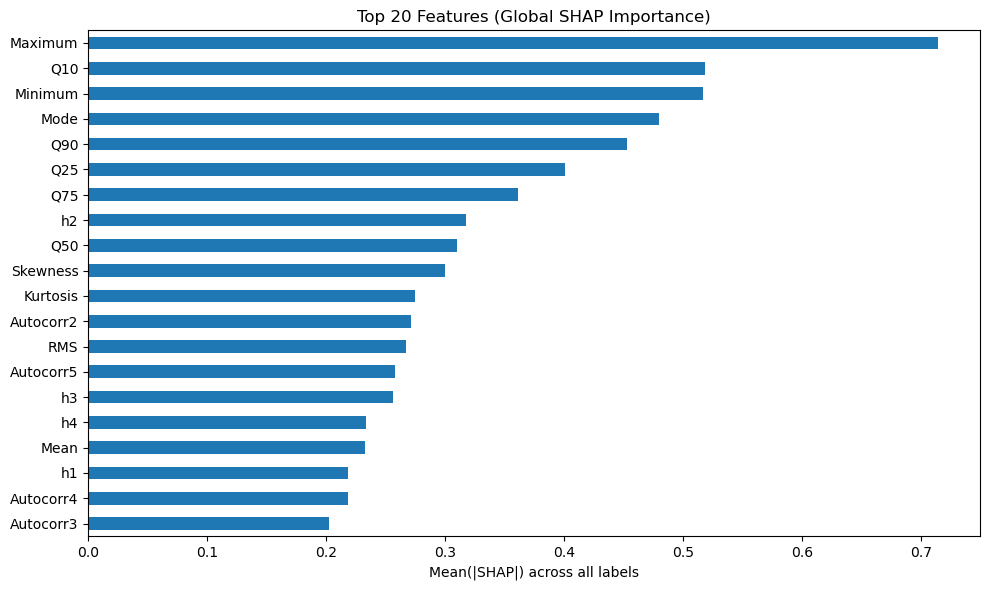

oestrus   calving  lameness  mastitis  other_disease  mean_global
Maximum    0.568287  0.685093  0.822469  0.860878       0.631243     0.713594
Q10        0.304761  0.795620  0.612601  0.372634       0.507094     0.518542
Minimum    0.304863  1.234463  0.281056  0.267487       0.494766     0.516527
Mode       0.410229  0.513021  0.289056  0.697843       0.486678     0.479365
Q90        0.397140  0.325441  0.459438  0.616309       0.466019     0.452869
Q25        0.165960  0.559686  0.301152  0.476980       0.497310     0.400218
Q75        0.308468  0.448013  0.166106  0.380557       0.500441     0.360717
h2         0.174401  0.148071  0.294115  0.594358       0.376670     0.317523
Q50        0.256339  0.175200  0.545906  0.350716       0.222101     0.310052
Skewness   0.208916  0.245253  0.478402  0.254780       0.312538     0.299978
Kurtosis   0.107938  0.465962  0.114697  0.443578       0.240130     0.274461
Autocorr2  0.186941  0.254166  0.300858  0.337232       0.278026     0.271444
RMS        0.132571  0.622260  0.184909  0.163031       0.234192     0.267393
Autocorr5  0.152848  0.533931  0.296275  0.116884       0.188706     0.257729
h3         0.192697  0.177527  0.222300  0.312192       0.377700     0.256483
h4         0.149386  0.221973  0.392201  0.233402       0.170856     0.233563
Mean       0.054606  0.283920  0.404847  0.195272       0.225584     0.232846
h1         0.177811  0.073508  0.297600  0.320685       0.221895     0.218300
Autocorr4  0.106793  0.332524  0.380381  0.151461       0.118235     0.217879
Autocorr3  0.068897  0.274180  0.366542  0.142199       0.160570     0.202478

In [ ]:
import shap
import numpy as np

# Stockage des SHAP moyens pour chaque feature par label
shap_matrix = pd.DataFrame(index=X_test.columns)

# Boucle sur chaque label
for i, target in enumerate(label):
    print(f"Traitement de la condition: {target}")

    single_model = multi_model.estimators_[i]
    explainer = shap.Explainer(single_model)
    shap_values = explainer(X_test)

    mean_shap = np.abs(shap_values.values).mean(axis=0)

    # Ajouter les valeurs dans la matrice
    shap_matrix[target] = mean_shap

# Moyenne globale des SHAP values par feature
shap_matrix['mean_global'] = shap_matrix.mean(axis=1)

# Tri des features par importance globale
shap_ranked = shap_matrix.sort_values('mean_global', ascending=False)

# Affichage du top 20
top_features = shap_ranked.head(20)

# Visualisation
plt.figure(figsize=(10, 6))
top_features['mean_global'].plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 Features (Global SHAP Importance)")
plt.xlabel("Mean(|SHAP|) across all labels")
plt.tight_layout()
plt.show()

display(top_features)


## Étape 3 : Sélectionner les features importantes with grid search to identify the threshold

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier

import numpy as np
import pandas as pd

# Train-test split (refait pour clarté)
X = df_32[feature_cols]
y = df_32[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Étape 1: Entraîner le modèle initial pour obtenir les SHAP values
base_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
multi_model = MultiOutputClassifier(base_model)
multi_model.fit(X_train, y_train)

# Calcul des SHAP moyens globaux
shap_matrix = pd.DataFrame(index=X_test.columns)

for i, target in enumerate(label):
    explainer = shap.Explainer(multi_model.estimators_[i])
    shap_values = explainer(X_test)
    mean_shap = np.abs(shap_values.values).mean(axis=0)
    shap_matrix[target] = mean_shap

shap_matrix['mean_global'] = shap_matrix.mean(axis=1)

# Étape 2: Essai de plusieurs seuils pour la sélection de features
thresholds = np.arange(0.05, 0.3, 0.02)
results = []

for threshold in thresholds:
    selected_features = shap_matrix[shap_matrix['mean_global'] >= threshold].index.tolist()

    if not selected_features:
        print(f"🔴 Seuil {threshold}: aucune feature sélectionnée.")
        continue

    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]

    model_sel = MultiOutputClassifier(xgb.XGBClassifier(eval_metric='logloss'))
    model_sel.fit(X_train_sel, y_train)

    y_pred = model_sel.predict(X_test_sel)

    # Évaluation multilabel
    f1 = np.mean([f1_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y.shape[1])])
    precision = np.mean([precision_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y.shape[1])])
    recall = np.mean([recall_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y.shape[1])])

    # Gestion AUC (nécessite predict_proba et au moins deux classes présentes)
    try:
        y_prob = np.column_stack([model_sel.estimators_[i].predict_proba(X_test_sel)[:, 1] for i in range(y.shape[1])])
        auc = np.mean([roc_auc_score(y_test.iloc[:, i], y_prob[:, i]) for i in range(y.shape[1])])
    except Exception as e:
        auc = np.nan

    print(f"✅ Seuil {threshold:.3f} | {len(selected_features)} features | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | AUC: {auc:.4f}")

    results.append({
        'threshold': threshold,
        'num_features': len(selected_features),
        'f1_macro': f1,
        'precision_macro': precision,
        'recall_macro': recall,
        'roc_auc_macro': auc
    })

# Résumé
results_df = pd.DataFrame(results)
display(results_df.sort_values(by='f1_macro', ascending=False))

C:\Users\rouat\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:15:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rouat\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:15:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rouat\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:15:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\rouat\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:15:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

✅ Seuil 0.050 | 32 features | F1: 0.8038 | Precision: 0.9788 | Recall: 0.6893 | AUC: 0.9952
✅ Seuil 0.070 | 32 features | F1: 0.8038 | Precision: 0.9788 | Recall: 0.6893 | AUC: 0.9952
✅ Seuil 0.090 | 31 features | F1: 0.8074 | Precision: 0.9723 | Recall: 0.6975 | AUC: 0.9963
✅ Seuil 0.110 | 30 features | F1: 0.8116 | Precision: 0.9851 | Recall: 0.6966 | AUC: 0.9955
✅ Seuil 0.130 | 28 features | F1: 0.8239 | Precision: 0.9776 | Recall: 0.7191 | AUC: 0.9961
✅ Seuil 0.150 | 28 features | F1: 0.8239 | Precision: 0.9776 | Recall: 0.7191 | AUC: 0.9961
✅ Seuil 0.170 | 23 features | F1: 0.8168 | Precision: 0.9841 | Recall: 0.7055 | AUC: 0.9964
✅ Seuil 0.190 | 22 features | F1: 0.8239 | Precision: 0.9806 | Recall: 0.7165 | AUC: 0.9943
✅ Seuil 0.210 | 19 features | F1: 0.8263 | Precision: 0.9796 | Recall: 0.7204 | AUC: 0.9955
✅ Seuil 0.230 | 17 features | F1: 0.8384 | Precision: 0.9850 | Recall: 0.7346 | AUC: 0.9958
✅ Seuil 0.250 | 15 features | F1: 0.8531 | Precision: 0.9834 | Recall: 0.7580 | 

threshold  num_features  f1_macro  precision_macro  recall_macro  \
10       0.25            15  0.853136         0.983405      0.758021   
12       0.29            10  0.844847         0.979287      0.750436   
9        0.23            17  0.838358         0.984977      0.734611   
11       0.27            12  0.832576         0.980098      0.730439   
8        0.21            19  0.826297         0.979599      0.720368   
7        0.19            22  0.823926         0.980622      0.716452   
4        0.13            28  0.823857         0.977628      0.719065   
5        0.15            28  0.823857         0.977628      0.719065   
6        0.17            23  0.816840         0.984077      0.705488   
3        0.11            30  0.811623         0.985069      0.696564   
2        0.09            31  0.807391         0.972342      0.697490   
0        0.05            32  0.803755         0.978771      0.689324   
1        0.07            32  0.803755         0.978771      0.689324   

    roc_auc_macro  
10       0.995408  
12       0.994595  
9        0.995750  
11       0.995436  
8        0.995530  
7        0.994327  
4        0.996127  
5        0.996127  
6        0.996367  
3        0.995454  
2        0.996343  
0        0.995163  
1        0.995163

### Optimal :Seuil 0.210 | 24 features | F1: 0.7872 | Precision: 0.9710 | Recall: 0.6714 | AUC: 0.9976

In [ ]:
threshold = 0.210
selected_features = shap_matrix[shap_matrix['mean_global'] >= threshold].index.tolist()

print(f"🎯 Seuil choisi = {threshold}")
print(f"✅ {len(selected_features)} features sélectionnées :\n{selected_features}")

🎯 Seuil choisi = 0.21
✅ 19 features sélectionnées :
['Minimum', 'Maximum', 'Mean', 'RMS', 'Mode', 'Q10', 'Q90', 'Q25', 'Q50', 'Q75', 'Skewness', 'Kurtosis', 'Autocorr2', 'Autocorr4', 'Autocorr5', 'h1', 'h2', 'h3', 'h4']


## Étape 4 : Refaire un modèle avec seulement les features sélectionnées (round 2)

In [ ]:
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

final_model = MultiOutputClassifier(xgb.XGBClassifier(eval_metric='logloss'))
final_model.fit(X_train_sel, y_train)

# Prédictions
y_pred = final_model.predict(X_test_sel)

# Évaluation
f1 = np.mean([f1_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y.shape[1])])
precision = np.mean([precision_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y.shape[1])])
recall = np.mean([recall_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y.shape[1])])

# AUC
try:
    y_prob = np.column_stack([final_model.estimators_[i].predict_proba(X_test_sel)[:, 1] for i in range(y.shape[1])])
    auc = np.mean([roc_auc_score(y_test.iloc[:, i], y_prob[:, i]) for i in range(y.shape[1])])
except:
    auc = np.nan

print("\n📊 Performances finales avec le seuil sélectionné :")
print(f"F1 score macro     : {f1:.4f}")
print(f"Precision macro    : {precision:.4f}")
print(f"Recall macro       : {recall:.4f}")
print(f"ROC AUC macro      : {auc:.4f}")


📊 Performances finales avec le seuil sélectionné :
F1 score macro     : 0.8263
Precision macro    : 0.9796
Recall macro       : 0.7204
ROC AUC macro      : 0.9955


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Exemple : charger votre dataframe (ici df)
df = pd.read_csv('32features_1hour_shift_1.csv')

# Exemple de colonnes à convertir (date/heure)
date_cols = ['start_time', 'end_time']

# Convertir les colonnes dates en timestamps numériques
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')  # convertir en datetime (mettre NaT si erreur)
    df[col] = df[col].astype('int64') // 10**9  # convertir en secondes depuis epoch (timestamp)

# Supprimer les lignes avec NaN éventuels après conversion (ou remplacer par une valeur)
df = df.fillna(0)

# Séparer features et cible
X = df.drop(columns=['OK'])  # 'OK' est la colonne cible
y = df['OK']

# Vérifier les types et sélectionner uniquement les colonnes numériques
X = X.select_dtypes(include=['int64', 'float64'])

print("Avant SMOTE :", Counter(y))

# Appliquer SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

print("Après SMOTE :", Counter(y_resampled))

Avant SMOTE : Counter({1: 97996, 0: 6845})


C:\Users\rouat\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\rouat\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\rouat\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rouat\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\rouat\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(e

Après SMOTE : Counter({1: 97996, 0: 97996})


In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter

# Exemple dataframe df déjà nettoyé et préparé (dates converties en timestamp, etc.)

# Liste des colonnes cibles à traiter
target_columns = ['OK', 'oestrus', 'lameness', 'mastitis', 'other_disease', 'calving']

# Sélectionne les colonnes numériques des features (à adapter)
X = df.drop(columns=target_columns)
X = X.select_dtypes(include=['int64', 'float64'])

for target in target_columns:
    print(f"\nTraitement de la cible : {target}")
    y = df[target]

    print("Avant SMOTE :", Counter(y))

    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)

    print("Après SMOTE :", Counter(y_res))


Traitement de la cible : OK
Avant SMOTE : Counter({1: 97996, 0: 6845})
Après SMOTE : Counter({1: 97996, 0: 97996})

Traitement de la cible : oestrus
Avant SMOTE : Counter({0: 100946, 1: 3895})
Après SMOTE : Counter({0: 100946, 1: 100946})

Traitement de la cible : lameness
Avant SMOTE : Counter({0: 104366, 1: 475})
Après SMOTE : Counter({0: 104366, 1: 104366})

Traitement de la cible : mastitis
Avant SMOTE : Counter({0: 104245, 1: 596})
Après SMOTE : Counter({0: 104245, 1: 104245})

Traitement de la cible : other_disease
Avant SMOTE : Counter({0: 103843, 1: 998})
Après SMOTE : Counter({0: 103843, 1: 103843})

Traitement de la cible : calving
Avant SMOTE : Counter({0: 103960, 1: 881})
Après SMOTE : Counter({0: 103960, 1: 103960})


In [ ]:
import pandas as pd
from collections import Counter
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata


minor_labels = ['calving', 'oestrus', 'lameness', 'mastitis', 'other_disease']

feature_cols = ['duration_hours', 'Minimum', 'Maximum', 'Mean', 'RMS', 'STD', 'MeanSTD6h',
                'STDMean6h', 'STDSD', 'RMSSD', 'Mode', 'Q10', 'Q90', 'Q25', 'Q50', 'Q75',
                'Skewness', 'Kurtosis', 'Autocorr1', 'Autocorr2', 'Autocorr3', 'Autocorr4',
                'Autocorr5', 'Autocorr6', 'Autocorr7', 'Autocorr8', 'Autocorr9', 'Autocorr10',
                'Autocorr11', 'h1', 'h2', 'h3', 'h4']

# 🧾 Afficher les counts AVANT augmentation
print("✅ Comptage des labels avant l’augmentation :\n")
for label in minor_labels + ['OK']:
    count_1 = df[label].sum()
    count_0 = len(df) - count_1
    print(f"{label:15s} : 1s = {int(count_1):6d} | 0s = {int(count_0):6d}")

synthetic_dfs = []

for label in minor_labels:
    print(f"\n🔄 Génération de données pour : {label}")

    # Étape 1 : Extraire les exemples avec label = 1
    minority_df = df[df[label] == 1]
    minority_df_features = minority_df[feature_cols]

    # Étape 2 : Définir les métadonnées
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(minority_df_features)

    # Étape 3 : Entraîner un CTGAN sur les données minoritaires
    synthesizer = CTGANSynthesizer(metadata)
    synthesizer.fit(minority_df_features)

    # Étape 4 : Générer des données synthétiques
    synthetic_data = synthesizer.sample(1000)  # à ajuster selon les besoins

    # Étape 5 : Ajouter les labels synthétiques
    for col in minor_labels + ['OK']:
        synthetic_data[col] = 1 if col == label else 0

    print("📊 Comptage des labels générés :")
    for col in minor_labels + ['OK']:
        count_1 = (synthetic_data[col] == 1).sum()
        count_0 = (synthetic_data[col] == 0).sum()
        print(f"Label '{col:15s}' - 1s: {count_1:4d} | 0s: {count_0:4d}")

    synthetic_dfs.append(synthetic_data)

# Étape 5 : Fusionner les données
synthetic_all = pd.concat(synthetic_dfs, ignore_index=True)
augmented_df = pd.concat([df, synthetic_all], ignore_index=True)

# 🧾 Afficher les counts APRÈS augmentation
print("\n✅ Comptage des labels APRÈS l’augmentation :\n")
print("\n✅ Comptage des labels APRÈS l’augmentation :\n")
for label in minor_labels + ['OK']:
    count_1 = augmented_df[label].sum()
    count_0 = len(augmented_df) - count_1
    print(f"{label:15s} : 1s = {int(count_1):6d} | 0s = {int(count_0):6d}")


✅ Comptage des labels avant l’augmentation :

calving         : 1s =    881 | 0s = 103960
oestrus         : 1s =   3895 | 0s = 100946
lameness        : 1s =    475 | 0s = 104366
mastitis        : 1s =    596 | 0s = 104245
other_disease   : 1s =    998 | 0s = 103843
OK              : 1s =  97996 | 0s =   6845

🔄 Génération de données pour : calving


C:\Users\rouat\anaconda3\Lib\site-packages\sdv\single_table\base.py:126: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
C:\Users\rouat\anaconda3\Lib\site-packages\sdv\single_table\base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


📊 Comptage des labels générés :
Label 'calving        ' - 1s: 1000 | 0s:    0
Label 'oestrus        ' - 1s:    0 | 0s: 1000
Label 'lameness       ' - 1s:    0 | 0s: 1000
Label 'mastitis       ' - 1s:    0 | 0s: 1000
Label 'other_disease  ' - 1s:    0 | 0s: 1000
Label 'OK             ' - 1s:    0 | 0s: 1000

🔄 Génération de données pour : oestrus


C:\Users\rouat\anaconda3\Lib\site-packages\sdv\single_table\base.py:126: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
C:\Users\rouat\anaconda3\Lib\site-packages\sdv\single_table\base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


📊 Comptage des labels générés :
Label 'calving        ' - 1s:    0 | 0s: 1000
Label 'oestrus        ' - 1s: 1000 | 0s:    0
Label 'lameness       ' - 1s:    0 | 0s: 1000
Label 'mastitis       ' - 1s:    0 | 0s: 1000
Label 'other_disease  ' - 1s:    0 | 0s: 1000
Label 'OK             ' - 1s:    0 | 0s: 1000

🔄 Génération de données pour : lameness


C:\Users\rouat\anaconda3\Lib\site-packages\sdv\single_table\base.py:126: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
C:\Users\rouat\anaconda3\Lib\site-packages\sdv\single_table\base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


📊 Comptage des labels générés :
Label 'calving        ' - 1s:    0 | 0s: 1000
Label 'oestrus        ' - 1s:    0 | 0s: 1000
Label 'lameness       ' - 1s: 1000 | 0s:    0
Label 'mastitis       ' - 1s:    0 | 0s: 1000
Label 'other_disease  ' - 1s:    0 | 0s: 1000
Label 'OK             ' - 1s:    0 | 0s: 1000

🔄 Génération de données pour : mastitis


C:\Users\rouat\anaconda3\Lib\site-packages\sdv\single_table\base.py:126: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
C:\Users\rouat\anaconda3\Lib\site-packages\sdv\single_table\base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


📊 Comptage des labels générés :
Label 'calving        ' - 1s:    0 | 0s: 1000
Label 'oestrus        ' - 1s:    0 | 0s: 1000
Label 'lameness       ' - 1s:    0 | 0s: 1000
Label 'mastitis       ' - 1s: 1000 | 0s:    0
Label 'other_disease  ' - 1s:    0 | 0s: 1000
Label 'OK             ' - 1s:    0 | 0s: 1000

🔄 Génération de données pour : other_disease


C:\Users\rouat\anaconda3\Lib\site-packages\sdv\single_table\base.py:126: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
C:\Users\rouat\anaconda3\Lib\site-packages\sdv\single_table\base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


📊 Comptage des labels générés :
Label 'calving        ' - 1s:    0 | 0s: 1000
Label 'oestrus        ' - 1s:    0 | 0s: 1000
Label 'lameness       ' - 1s:    0 | 0s: 1000
Label 'mastitis       ' - 1s:    0 | 0s: 1000
Label 'other_disease  ' - 1s: 1000 | 0s:    0
Label 'OK             ' - 1s:    0 | 0s: 1000

✅ Comptage des labels APRÈS l’augmentation :


✅ Comptage des labels APRÈS l’augmentation :

calving         : 1s =   1881 | 0s = 107960
oestrus         : 1s =   4895 | 0s = 104946
lameness        : 1s =   1475 | 0s = 108366
mastitis        : 1s =   1596 | 0s = 108245
other_disease   : 1s =   1998 | 0s = 107843
OK              : 1s =  97996 | 0s =  11845
